# Predicting House Prices

This project aims to produce a viable model for predicting housing prices based on collected information about house features. 

The data set describes the sale of individual residential property in Ames, Iowa from 2006 to 2010

Detailed information about the structure of the data set can be found at the following link:

__[Data Documentation](https://ww2.amstat.org/publications/jse/v19n3/decock/DataDocumentation.txt)__

__[Study Documentation](https://ww2.amstat.org/publications/jse/v19n3/decock.pdf)__

In [58]:
import re
import pandas as pd
from pandas.api.types import is_numeric_dtype
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, StandardScaler, scale
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from scipy.stats import skew

%matplotlib inline

# Setting some default graph styles
sns.set_style("white", {'axes.edgecolor': '#b2b2b2'})
sns.set_context("notebook", font_scale=1.25)

In the initial analysis of the data documentation, it became clear that the data made extensive use of the value 'NA' to indicate that a feature of the house was not present.  For instance, the Garage Finish feature is described thusly:

Garage Finish (Ordinal)	: Interior finish of the garage

       Fin	Finished
       RFn	Rough Finished	
       Unf	Unfinished
       NA	No Garage


In this case 'NA' does not mean "no data about the Garage Finish was recorded".  It means "we know that this house does not have a garage, therefore there is no data about the Garage Finish".  This is an important distinction as the NA value does indeed tell us something about the house.  

That being said, let's remove 'NA' from the list of things Pandas looks for when deciding if a field is empty.

In [2]:
# Redefining the list of items Pandas considers empty

na_list = ['', '#N/A', '#N/A N/A', '#NA', '-1.#IND', '-1.#QNAN', '-NaN', '-nan',
    '1.#IND', '1.#QNAN', 'N/A', 'NULL', 'NaN', 'n/a', 'nan',
    'null']

In [3]:
housing = pd.read_csv('AmesHousing.tsv', '\t', 
                      na_values=na_list, keep_default_na=False)

In [4]:
housing.head()

,Order,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
0,1,526301100,20,RL,141.0,31770,Pave,NA,IR1,Lvl,...,0,NA,NA,NA,0,5,2010,WD,Normal,215000
1,2,526350040,20,RH,80.0,11622,Pave,NA,Reg,Lvl,...,0,NA,MnPrv,NA,0,6,2010,WD,Normal,105000
2,3,526351010,20,RL,81.0,14267,Pave,NA,IR1,Lvl,...,0,NA,NA,Gar2,12500,6,2010,WD,Normal,172000
3,4,526353030,20,RL,93.0,11160,Pave,NA,Reg,Lvl,...,0,NA,NA,NA,0,4,2010,WD,Normal,244000
4,5,527105010,60,RL,74.0,13830,Pave,NA,IR1,Lvl,...,0,NA,MnPrv,NA,0,3,2010,WD,Normal,189900


# Data Analysis and Cleaning

First and foremost the Study Documentation indicates that there are some extreme outliers in the data that should be removed.  It recommends that any entries with a ***Gr Liv Area*** greater than 4000 sq. ft. should be removed.


In [5]:
house_area = housing['Gr Liv Area'] < 4000
housing = housing[house_area]
housing.shape[0]

2925

Now let's see how the data looks with regard to missing values.

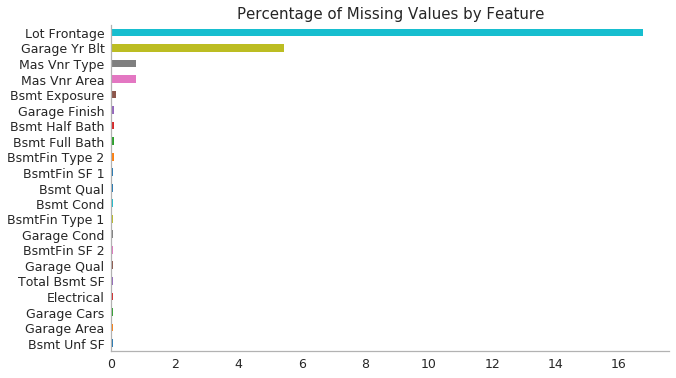

In [6]:
housing[housing.columns[housing.isnull().any()]].isnull().sum().sort_values().apply(lambda x: x / housing.shape[0] * 100).plot(kind='barh', figsize=(10,6))
plt.title('Percentage of Missing Values by Feature')
sns.despine()

The data documentation states the following about these features:

* Lot Frontage (Continuous): Linear feet of street connected to property
* Garage Yr Blt (Discrete): Year garage was built
* Mas Vnr Type (Nominal): Masonry veneer type
* Mas Vnr Area (Continuous): Masonry veneer area in square feet
* Bsmt Exposure	(Ordinal): Refers to walkout or garden level walls
* Garage Finish (Ordinal)	: Interior finish of the garage
* Bsmt Half Bath (Discrete): Basement half bathrooms
* Bsmt Full Bath (Discrete): Basement full bathrooms
* BsmtFinType 2	(Ordinal): Rating of basement finished area (if multiple types)
* Garage Qual (Ordinal): Garage quality
* Garage Area (Continuous): Size of garage in square feet
* Garage Cars (Discrete): Size of garage in car capacity
* Electrical (Ordinal): Electrical system
* Total Bsmt SF (Continuous): Total square feet of basement area
* Bsmt Qual (Ordinal): Evaluates the height of the basement
* BsmtFin SF 2 (Continuous): Type 2 finished square feet
* Garage Cond (Ordinal): Garage condition
* BsmtFin Type 1 (Ordinal): Rating of basement finished area
* Bsmt Cond (Ordinal): Evaluates the general condition of the basement
* BsmtFin SF 1 (Continuous): Type 1 finished square feet
* Bsmt Unf SF (Continuous): Unfinished square feet of basement area


Let's first address Lot Frontage.  The data set contains a feature called Lot Config, which is described thusly:

Lot Config (Nominal): Lot configuration

       Inside	Inside lot
       Corner	Corner lot
       CulDSac	Cul-de-sac
       FR2	Frontage on 2 sides of property
       FR3	Frontage on 3 sides of property
       
Based on research into these different lot types from this source __[Real Estate Lot Types](https://www.thetruthaboutrealty.com/real-estate-lot-types/)__, all five of those lot configurations indicate some frontage to the street.  Since we know that there are no observations missing a "Lot Config" value, we can conclude that every observation should have some measureable length of Lot Frontage.

The Lot Config could potentially lead to very large differences in Lot Frontage (imagine the same house/lot as an Inside lot vs. a FR3 lot).  Rather than taking the mean of the entire feature for imputation, let's use the mean from each Lot Type and fill in accordingly.

In [7]:
lot_configs = housing['Lot Config'].unique()

In [8]:
def dict_fill(input_list, target, target_val, default_val):
    '''
    Creates a dictionary that sets the value for every key to 
    a default value, with the exception of the target.  The 
    Target receives the target_val.
    '''
    
    target_dict = {}
    
    for item in input_list:
        
        if item == target:
            target_dict[item] = target_val
        else:
            target_dict[item] = default_val
            
    return target_dict

In [9]:
def cond_fill(row, test_col, target_col, values):
    
    if pd.isnull(row[test_col]) or (not pd.isnull(row[target_col]) and row[target_col] != 'NA'):
        return row[target_col]
    
    else:
        return values.get(row[test_col], row[target_col])

In [10]:
# Making a dictionary of Lot Frontage means based on Lot Config and
# conditionally filling in the missing Lot Frontage values

lot_conf_means = {}

for config in lot_configs:
    lot_conf_means[config] = housing[housing['Lot Config'] == config]['Lot Frontage'].mean()
    
housing['Lot Frontage'] = housing.apply(cond_fill, args=('Lot Config', 'Lot Frontage', lot_conf_means), axis=1)
housing['Lot Frontage'].isnull().sum()

0

Let's look at the missing Garage features as a group to get an idea of what is going on with their missing values.

In [11]:
myre = re.compile("^Garage.*")
garage_feat = [name for name in housing.columns if myre.match(name)]

In [12]:
housing[housing[garage_feat].isnull().any(axis=1)][garage_feat].style.highlight_null(null_color='orange')

,Garage Type,Garage Yr Blt,Garage Finish,Garage Cars,Garage Area,Garage Qual,Garage Cond
27,NA,nan,NA,0,0,NA,NA
119,NA,nan,NA,0,0,NA,NA
125,NA,nan,NA,0,0,NA,NA
129,NA,nan,NA,0,0,NA,NA
130,NA,nan,NA,0,0,NA,NA
170,NA,nan,NA,0,0,NA,NA
171,NA,nan,NA,0,0,NA,NA
186,NA,nan,NA,0,0,NA,NA
203,NA,nan,NA,0,0,NA,NA
206,NA,nan,NA,0,0,NA,NA


Let's use ***Garage Type*** as an indicator of whether or not a house has a Garage.  With that in mind let's see what the most plentiful entries are for the categorical Garage features.

In [13]:
# Retrieving the mode for the three categorical Garage features

garage_finish_mode = housing['Garage Finish'].mode()[0]
garage_qual_mode = housing['Garage Qual'].mode()[0]
garage_cond_mode = housing['Garage Cond'].mode()[0]

In [14]:
# Building dictionaries to use for conditional filling of the
# missing values

garage_types = housing['Garage Type'].unique()
garage_finish_dict = dict_fill(garage_types, 'NA', 'NA', garage_finish_mode)
garage_qual_dict = dict_fill(garage_types, 'NA', 'NA', garage_qual_mode)
garage_cond_dict = dict_fill(garage_types, 'NA', 'NA', garage_cond_mode)

In [15]:
# If the Garage Type is NA then set the missing values to NA
# Otherwise set the value to the mode

housing['Garage Finish'] = housing.apply(cond_fill, args=('Garage Type', 'Garage Finish', garage_finish_dict), axis=1)
housing['Garage Qual'] = housing.apply(cond_fill, args=('Garage Type', 'Garage Qual', garage_qual_dict), axis=1)
housing['Garage Cond'] = housing.apply(cond_fill, args=('Garage Type', 'Garage Cond', garage_cond_dict), axis=1)

If a house has a ***Garage Type*** set but nothing in the ***Garage Cars*** or ***Garage Area***, we'll set ***Garage Cars*** to 1 and set the ***Garage Area*** to the mean value for single car garages.

In [16]:
garage_area_mean = housing[housing['Garage Cars'] == 1]['Garage Area'].mean()

garage_cars_dict = dict_fill(garage_types, 'NA', 0, 1)
garage_area_dict = dict_fill(garage_types, 'NA', 0, garage_area_mean)

housing['Garage Cars'] = housing.apply(cond_fill, args=('Garage Type', 'Garage Cars', garage_cars_dict), axis=1)
housing['Garage Area'] = housing.apply(cond_fill, args=('Garage Type', 'Garage Area', garage_area_dict), axis=1)

Finally, let's fill in ***Garage Yr Blt*** with 2010 if it is missing, this will help with calculating the age of the garage later.  We'll be creating a new binary feature later that indicates if the house has a garage or not.  

In [17]:
housing['Garage Yr Blt'].fillna(2010, inplace=True)

For ***Mas Vnr Type*** and ***Mas Vnr Area*** let's assume that if these values are missing then the house has no Masonry Veneer.  We'll set ***Mas Vnr Type*** to 'None' and ***Mas Vnr Area*** to 0.

In [18]:
housing['Mas Vnr Type'].fillna('None', inplace=True)
housing['Mas Vnr Area'].fillna(0, inplace=True)

Let's look at the missing Basement features as a group to get an idea of what is going on with their missing values.

In [19]:
# Building a list of Basement features

myre = re.compile(".*Bsmt.*")

bsmt_feat = [name for name in housing.columns if myre.match(name)]

In [20]:
# Grabbing any row where any Basement feature is empty

housing[housing[bsmt_feat].isnull().any(axis=1)][bsmt_feat].style.highlight_null(null_color='orange')

,Bsmt Qual,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin SF 1,BsmtFin Type 2,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,Bsmt Full Bath,Bsmt Half Bath
66,Gd,TA,nan,Unf,0,Unf,0,1595,1595,0,0
444,Gd,TA,No,GLQ,1124,nan,479,1603,3206,1,0
1341,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
1497,NA,NA,NA,NA,0,NA,0,0,0,nan,nan
1796,Gd,TA,nan,Unf,0,Unf,0,725,725,0,0
2779,Gd,TA,nan,Unf,0,Unf,0,936,936,0,0


Let's use ***Bsmt Qual*** as the indicator of whether or not the house has a basement.  If it is null then we'll subtitute NA 

In [21]:
housing['Bsmt Qual'].fillna(value='NA', inplace=True)

If ***Bsmt Qual*** is NA then all of the other Basement features should be NA or 0 if they are empty.

In [22]:
housing['Bsmt Cond'].mask((pd.isnull(housing['Bsmt Cond'])) & (housing['Bsmt Qual'] == 'NA'), 'NA', inplace=True)
housing['Bsmt Exposure'].mask((pd.isnull(housing['Bsmt Exposure'])) & (housing['Bsmt Qual'] == 'NA'), 'NA', inplace=True)
housing['BsmtFin Type 1'].mask((pd.isnull(housing['BsmtFin Type 1'])) & (housing['Bsmt Qual'] == 'NA'), 'NA', inplace=True)
housing['BsmtFin SF 1'].mask((pd.isnull(housing['BsmtFin SF 1'])) & (housing['Bsmt Qual'] == 'NA'), 0, inplace=True)
housing['BsmtFin Type 2'].mask((pd.isnull(housing['BsmtFin Type 2'])) & (housing['Bsmt Qual'] == 'NA'), 'NA', inplace=True)
housing['BsmtFin SF 2'].mask((pd.isnull(housing['BsmtFin SF 2'])) & (housing['Bsmt Qual'] == 'NA'), 0, inplace=True)
housing['Bsmt Unf SF'].mask((pd.isnull(housing['Bsmt Unf SF'])) & (housing['Bsmt Qual'] == 'NA'), 0, inplace=True)
housing['Total Bsmt SF'].mask((pd.isnull(housing['Total Bsmt SF'])) & (housing['Bsmt Qual'] == 'NA'), 0, inplace=True)
housing['Bsmt Full Bath'].mask((pd.isnull(housing['Bsmt Full Bath'])) & (housing['Bsmt Qual'] == 'NA'), 0, inplace=True)
housing['Bsmt Half Bath'].mask((pd.isnull(housing['Bsmt Half Bath'])) & (housing['Bsmt Qual'] == 'NA'), 0, inplace=True)

Filling in the remaining missing Basement features

In [23]:
housing['Bsmt Exposure'].fillna(value='No', inplace=True)
housing['BsmtFin Type 2'].fillna(value=housing['BsmtFin Type 2'].mode()[0], inplace=True)

So that leaves one final feature that has missing values, ***Electrical***.  Let's use mode again to fill it in with the most plentiful choice.

In [24]:
housing['Electrical'].fillna(housing['Electrical'].mode()[0], inplace=True)

A final check to see if there are any other missing values.

In [25]:
housing.isnull().sum().sum()

0

Both the Order and PID features are not meaningful to the model.  Let's drop them.

In [26]:
housing.drop(['Order', 'PID'], inplace=True, axis=1)

## Engineering New Features

Based on the data analysis there are a number of features we can create that may be beneficial for our model and prediction.


***Has Garage***

    If any of the Garage features have something other than NA then this is 1 otherwise 0
    
***Has Basement***

    If any of the Basement features have something other than NA then this is 1 otherwise 0
    
***Has Porch***

    If any of the Porch features have something other than NA then this is 1 otherwise 0
    
***House Age***

    Difference between 2010 and the year the house was built
    
***Garage Rel Age***

    The House Age minus the age of the Garage
    
***Remod Rel Age***

    The House Age minus the age of the latest Remodel

In [27]:
# Building a list of Porch features

myre = re.compile(".*Porch.*")

porch_feat = [name for name in housing.columns if myre.match(name)]

In [28]:
# Because we filled in the values for Garage Yr Blt above, we don't want to use it
# to determine whether or not a house has a garage.

garage_feat.remove('Garage Yr Blt')

def new_feature(row, feat_list):
    
    '''
    Assigns a value to a new binary feature by examining all of the
    feature values of the passed in list.  If any of features have
    legitimate values in them, the feature is assigned a 1.  Otherwise
    it is assigned a 0.
    '''
    
    feat_val = '0'
    
    for feat in feat_list:
        if row[feat] != 'NA' and row[feat] != 0:
            feat_val = '1'
    
    return feat_val


# Creating new binary features
housing['Has Garage'] = housing.apply(new_feature, args=(garage_feat,), axis=1)
housing['Has Basement'] = housing.apply(new_feature, args=(bsmt_feat,), axis=1)
housing['Has Porch'] = housing.apply(new_feature, args=(porch_feat,), axis=1)

# Creating new "Age" features
housing['House Age'] = 2010 - housing['Year Built']
housing['Garage Rel Age'] = housing['Garage Yr Blt'] - housing['Year Built']
housing['Remod Rel Age'] = housing['Year Remod/Add'] - housing['Year Built']
housing['Garage Rel Age'] = housing['Garage Rel Age'].apply(lambda x: x + abs(housing['Garage Rel Age'].min()))
housing['Remod Rel Age'] = housing['Remod Rel Age'].apply(lambda x: x + abs(housing['Remod Rel Age'].min()))

Since we have created new "Age" features, we no longer need the original "Year" features.

In [29]:
housing.drop(['Year Built', 'Year Remod/Add', 'Yr Sold', 'Garage Yr Blt'], inplace=True, axis=1)

Pandas imported the ***MS SubClass*** feature as an integer, but it is actually categorical.  Let's change the type so it gets picked up by get_dummies later.

In [30]:
housing['MS SubClass'] = housing['MS SubClass'].astype('category')

## Normalization, Skew and Category Conversion


Let's convert all of the numeric columns in the dataframe to float64 for consistency.

In [31]:
numeric_feats = []

for feat in housing.columns:
    if is_numeric_dtype(housing[feat]):
        numeric_feats.append(feat)
        
        
housing[numeric_feats] = housing[numeric_feats].astype('float64')

Now we adjust the scale of the features so that no one feature unduly influences the outcome.  We preserve the SalePrice column as is so that we can get readable predictions out of our model.

In [32]:
mms = MinMaxScaler()

for feat in numeric_feats: 
    if feat != 'SalePrice':
        housing[feat] = mms.fit_transform(housing[[feat]].values)

Now we look at how skewed the features are and try to get them into more of a normal distribution using log1p

In [33]:
skewed_feats = housing[numeric_feats].apply(lambda x: skew(x))
skewed_feats = skewed_feats[skewed_feats > 0.75]
skewed_feats = list(skewed_feats.index)
#skewed_feats.remove('SalePrice')
housing[skewed_feats] = np.log1p(housing[skewed_feats])

Finally we us Pandas get_dummies to expand all of the categorical features into binary features.

In [34]:
housing = pd.get_dummies(housing, drop_first=True)

## Machine Learning Model

In [35]:
# Splitting the data into a feature matrix (X) and a label vector (y)

X = housing.drop('SalePrice', axis=1)
y = housing['SalePrice'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30)

In [36]:
rmse_list = []
r2_list = []

In [37]:
# Originally, LinearRegression was the target algorithm.
# However, after several attempts to deal with collinearity in the data set,
# it became apparent that multicollinearity was a problem.  Thus the switch 
# was made to Ridge Regression which is able to handle multicollinearity.

# Creating a list of alpha values to test in the Ridge algorithm

alphas = [1e-15, 1e-10, 1e-8, 0.0001, 0.001, 0.01]
alphas.extend(list(range(1,11)))

for a in alphas:

    kf = KFold(5, shuffle=True)
       
    rr = Ridge(alpha=a)
   
    rmse_list.append(abs(cross_val_score(rr, X_train, y_train, scoring="neg_mean_squared_error", cv=kf).mean()) ** .5)
    r2_list.append(cross_val_score(rr, X_train, y_train, scoring="r2", cv=kf).mean())


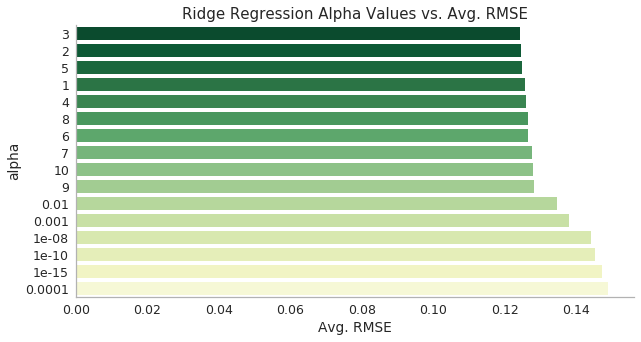

In [38]:
rmse_df = pd.DataFrame({'alpha': [str(x) for x in alphas], 'Avg. RMSE': rmse_list})
rmse_df.sort_values(by='Avg. RMSE', inplace=True)

plt.figure(figsize=(10,5))
sns.barplot(rmse_df['Avg. RMSE'],
            rmse_df['alpha'],
            orient='h',
            order=rmse_df['alpha'],
            palette=sns.color_palette("YlGn_r", rmse_df.shape[0])
           ).set_title('Ridge Regression Alpha Values vs. Avg. RMSE');
sns.despine()

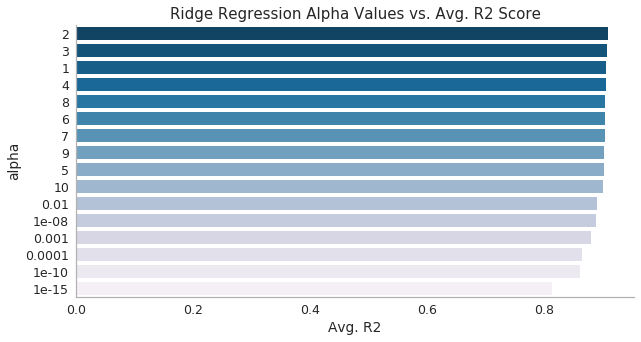

In [39]:
r2_df = pd.DataFrame({'alpha': [str(x) for x in alphas], 'Avg. R2': r2_list})
r2_df.sort_values(by='Avg. R2', inplace=True, ascending=False)

plt.figure(figsize=(10,5))
sns.barplot(r2_df['Avg. R2'],
            r2_df['alpha'],
            orient='h',
            order=r2_df['alpha'],
            palette=sns.color_palette("PuBu_r", r2_df.shape[0])
           ).set_title('Ridge Regression Alpha Values vs. Avg. R2 Score');
sns.despine()

In [46]:
rr = Ridge(alpha=2)

rr.fit(X_train, y_train)

prediction = rr.predict(X_test)
rmse = mean_squared_error(y_test, prediction) ** .5
r2 = r2_score(y_test, prediction)

In [67]:
result_df = pd.DataFrame({'Actual': y_test, 'Prediction': prediction})

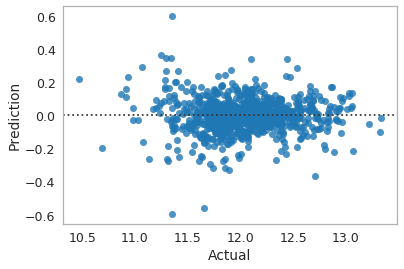

In [68]:
sns.residplot(x='Actual', y='Prediction', data=result_df)

In [69]:
r2

0.9310054683524529

In [63]:
rmse

0.10636579976511507